# Correlation of Oceanic Nino Index and Fire Weather Index With Emphasis on The Amazon Rainforest Region of South America

### Import modules and load data

In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import glob
import numpy as np
import datetime
import xarray as xr
from matplotlib import pyplot as plt
from scipy import stats
import math
from datetime import date
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
#This creates the data paths text file that was submitted
#using the the wget command (wget -i nc_file_paths.txt) all the data can be downloaded
start_str = 'https://portal.nccs.nasa.gov/datashare/GlobalFWI/v2.0/fwiCalcs.MERRA2/Default/MERRA2/'
mid_str = '/FWI.MERRA2.Monthly.Default.'
months = [31,28,31,30,31,30,31,31,30,31,30,31]
month = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
day = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
paths_list = []
temp_str = 'temp'
for i in range(40):
    for j in range(12):
            temp_str = start_str + str(1981+i) + mid_str + str(1981+i) +month[j]  + '.nc'
            paths_list.append(temp_str)
#print(paths_list)   
with open('nc_file_paths.txt', 'w') as paths:
    for listitem in paths_list:
        paths.write('%s\n' % listitem)

In [16]:
#Load data from 476 .nc files 

dt_parse = '%Y%m'
def get_date_num(stri):
    date1 = datetime.datetime.strptime(stri, dt_parse)
    return(date.toordinal(date1.date()))
list_of_paths = glob.glob('C:/Users/Patrick/Desktop/175_final/global_fwi_analysis/FWI_nc\'s/*.nc', recursive=True)
nc_list = []
nc_date_list = []
nc_date_key = []
nc_date_int = []
for path in list_of_paths:
    nc_list.append(nc.Dataset(path))
    nc_date_list.append(get_date_num(path[-9:-3]))
    nc_date_key.append(int(path[-9:-3]))
sample = nc_list[0]

### Process data

In [3]:
normed_date = np.round(np.array(nc_date_list) - np.mean(np.array(nc_date_list)))
print(len(normed_date))

476


In [4]:
fwi = []
for i in nc_list:
    fwi.append(i['MERRA2_FWI'][0])
fwi_array = np.dstack(fwi)

<ipython-input-4-9e0b1f9b52d8>:3: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  fwi.append(i['MERRA2_FWI'][0])
<ipython-input-4-9e0b1f9b52d8>:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  fwi.append(i['MERRA2_FWI'][0])


In [5]:
#Computes the Yearly Averages

years = list(range(1982, 2020))
for i in range(len(years)):
    years[i] = str(years[i])
#print(years)
yearly_list = []

for year in years:
    temp_array_list = []
    for i in range(476):
        if(nc_date_key[i][0:4] == year):
            temp_array_list.append(fwi_array[:,:,i])
    #print(len(temp_array_list))
    avg_array = np.empty((267,576))
    avg_array[:] = np.nan
    for j in range(267):
        for k in range(576):
            point_list = []
            for q in range(len(temp_array_list)):
                point_list.append(temp_array_list[q][j,k])
            avg_array[j,k] = np.nanmean(np.array(point_list))
    yearly_list.append(avg_array)
    print(str(100*(int(year) - int(years[0]))/ (int(years[-1])-int(years[0]))) + '%')

<ipython-input-5-d13599030f6a>:22: RuntimeWarning: Mean of empty slice
  avg_array[j,k] = np.nanmean(np.array(point_list))


0.0%
2.7027027027027026%
5.405405405405405%
8.108108108108109%
10.81081081081081%
13.513513513513514%
16.216216216216218%
18.91891891891892%
21.62162162162162%
24.324324324324323%
27.027027027027028%
29.72972972972973%
32.432432432432435%
35.13513513513514%
37.83783783783784%
40.54054054054054%
43.24324324324324%
45.945945945945944%
48.648648648648646%
51.351351351351354%
54.054054054054056%
56.75675675675676%
59.45945945945946%
62.16216216216216%
64.86486486486487%
67.56756756756756%
70.27027027027027%
72.97297297297297%
75.67567567567568%
78.37837837837837%
81.08108108108108%
83.78378378378379%
86.48648648648648%
89.1891891891892%
91.89189189189189%
94.5945945945946%
97.29729729729729%
100.0%


In [6]:
year_from_start = np.array(list(range(34)))
yearly_array = np.dstack(yearly_list)
years_int = np.empty([38])
for i in range(len(years)):
    years_int[i] = int(years[i])
normed_year = np.array(years_int)-np.nanmean(np.array(years_int))

In [7]:
#Generates linear trend and removes the trend from the FWI 

t_trend_slope = np.empty([267, 576])
t_trend_intercept = np.empty([267, 576])
t_trend_rvalue = np.empty([267, 576])
t_trend_pvalue = np.empty([267, 576])
t_trend_stderr = np.empty([267, 576])

t_fwi_point = np.empty([476])
for i in range(267):
    for j in range(576):
        t_fwi_point = fwi_array[i,j,:]
        #print(np.nanmean(fwi_point))
        if((~np.isnan(np.nanmean(t_fwi_point)))):
            #print(np.nanmean(fwi_point))
            mask = ~np.isnan(t_fwi_point) & ~np.isnan(normed_date)
            t_trend_slope[i,j], t_trend_intercept[i,j], t_trend_rvalue[i,j], t_trend_pvalue[i,j], t_trend_stderr[i,j] = stats.linregress(normed_date[mask], t_fwi_point[mask])
        else:
            t_trend_slope[i,j] = np.float('NaN')
            t_trend_pvalue[i,j] = np.float('NaN')
            
fwi_detrend = np.empty((267, 576, 476))
for i in range(476):
    fwi_detrend[:,:,i] = fwi_array[:,:,i] - normed_date[i]*t_trend_slope[:,:]        

<ipython-input-7-a60a50410ec8>:14: RuntimeWarning: Mean of empty slice
  if((~np.isnan(np.nanmean(t_fwi_point)))):
C:\Users\Patrick\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
C:\Users\Patrick\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\Patrick\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [8]:
#Generates linear trend and removes the trend from the FWI yearly database

ty_trend_slope = np.empty([267, 576])
ty_trend_intercept = np.empty([267, 576])
ty_trend_rvalue = np.empty([267, 576])
ty_trend_pvalue = np.empty([267, 576])
ty_trend_stderr = np.empty([267, 576])

ty_fwi_point = np.empty([38])
for i in range(267):
    for j in range(576):
        ty_fwi_point = yearly_array[i,j,:]
        #print(np.nanmean(fwi_point))
        if((~np.isnan(np.nanmean(ty_fwi_point)))):
            #print(np.nanmean(fwi_point))
            mask = ~np.isnan(ty_fwi_point) & ~np.isnan(normed_year)
            ty_trend_slope[i,j], ty_trend_intercept[i,j], ty_trend_rvalue[i,j], ty_trend_pvalue[i,j], ty_trend_stderr[i,j] = stats.linregress(normed_year[mask], ty_fwi_point[mask])
        else:
            ty_trend_slope[i,j] = np.float('NaN')
            ty_trend_pvalue[i,j] = np.float('NaN')
            
fwi_y_detrend = np.empty((267, 576, 38))
for i in range(38):
    fwi_y_detrend[:,:,i] = yearly_array[:,:,i] - normed_year[i]*ty_trend_slope[:,:]        

<ipython-input-8-611448ccafc6>:14: RuntimeWarning: Mean of empty slice
  if((~np.isnan(np.nanmean(ty_fwi_point)))):


In [53]:
#Removes the seasonal cycle by differencing

def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)
fwi_re_season = np.empty([267, 576, 464]) 
for i in range(267):
    for j in range(576):
        fwi_re_season[i,j,:] = difference(fwi_detrend[i,j],12)

In [9]:
#compiles the monthly data into three month averages to match the ONI data

def three_month_avg(dataset, index):
    temp_array = np.empty([267,576])
    for i in range(267):
        for j in range(576):
            temp_array[i,j] =np.nanmean(np.array([dataset[i,j,index], dataset[i,j,index+1], dataset[i,j,index+2]]))
    return(temp_array)
three_month_list = []
for i in range(476):
    three_month_list.append(three_month_avg(fwi_detrend, i))
    print(str((i/464)*100)+'%')
    
    

<ipython-input-9-f4792fb21bc9>:7: RuntimeWarning: Mean of empty slice
  temp_array[i,j] =np.nanmean(np.array([dataset[i,j,index], dataset[i,j,index+1], dataset[i,j,index+2]]))


0.0%
0.21551724137931033%
0.43103448275862066%
0.646551724137931%
0.8620689655172413%
1.0775862068965518%
1.293103448275862%
1.5086206896551724%
1.7241379310344827%
1.9396551724137931%
2.1551724137931036%
2.3706896551724137%
2.586206896551724%
2.8017241379310347%
3.0172413793103448%
3.2327586206896552%
3.4482758620689653%
3.6637931034482754%
3.8793103448275863%
4.094827586206897%
4.310344827586207%
4.525862068965517%
4.741379310344827%
4.956896551724138%
5.172413793103448%
5.387931034482758%
5.603448275862069%
5.818965517241379%
6.0344827586206895%
6.25%
6.4655172413793105%
6.68103448275862%
6.896551724137931%
7.112068965517242%
7.327586206896551%
7.543103448275862%
7.758620689655173%
7.974137931034483%
8.189655172413794%
8.405172413793103%
8.620689655172415%
8.836206896551724%
9.051724137931034%
9.267241379310345%
9.482758620689655%
9.698275862068966%
9.913793103448276%
10.129310344827585%
10.344827586206897%
10.560344827586206%
10.775862068965516%
10.991379310344827%
11.2068965517241

93.75%
93.96551724137932%
94.18103448275862%
94.39655172413794%
94.61206896551724%
94.82758620689656%
95.04310344827587%
95.25862068965517%
95.47413793103449%
95.6896551724138%
95.90517241379311%
96.12068965517241%
96.33620689655173%
96.55172413793103%
96.76724137931035%
96.98275862068965%
97.19827586206897%
97.41379310344827%
97.62931034482759%
97.84482758620689%
98.0603448275862%
98.27586206896551%
98.49137931034483%
98.70689655172413%
98.92241379310344%
99.13793103448276%
99.35344827586206%
99.56896551724138%
99.78448275862068%
100.0%
100.21551724137932%
100.43103448275863%
100.64655172413792%
100.86206896551724%
101.07758620689656%
101.29310344827587%
101.50862068965519%
101.72413793103448%
101.9396551724138%


IndexError: index 476 is out of bounds for axis 2 with size 476

In [10]:
three_month_avg = np.dstack(three_month_list)
print(np.shape(three_month_avg))

(267, 576, 474)


In [287]:
#Load ONI data

oni_raw = np.genfromtxt('oni.csv', delimiter=',')
#print(np.shape(oni_raw))
oni_list = []
for i in range(39):
    for j in range(12):
        oni_list.append(oni_raw[i,j])
ONI = np.array(oni_list[:464])
#print(len(ONI))

yONI = np.genfromtxt('oni_yearly.csv', delimiter=',')
#print(np.shape(oni_raw))

print(len(yONI))

38


In [301]:
#Correlate the three month average data with the ONI data

m_coeff = np.empty([267, 576])

oni_fwi_point = np.empty([462])
for i in range(267):
    for j in range(576):
        oni_fwi_point = three_month_avg[i,j,:]
        #print(np.nanmean(fwi_point))
        if((~np.isnan(np.nanmean(oni_fwi_point)))):
            #print(np.nanmean(fwi_point))
            mask = ~np.isnan(oni_fwi_point[:]) & ~np.isnan(ONI[1:-1])
            m_coeff[i,j] = (np.corrcoef(ONI[1:-1][mask], oni_fwi_point[:][mask]))[0,1]
        else:
            m_coeff[i,j] = np.float('NaN')

<ipython-input-301-ce5ba23a2f79>:10: RuntimeWarning: Mean of empty slice
  if((~np.isnan(np.nanmean(oni_fwi_point)))):


In [309]:
t_coeff = np.empty([267, 576])

oni_fwi_point2 = np.empty([38])
for i in range(267):
    for j in range(576):
        oni_fwi_point2 = fwi_y_detrend[i,j,:]
        #print(np.nanmean(fwi_point))
        if((~np.isnan(np.nanmean(oni_fwi_point2)))):
            #print(np.nanmean(fwi_point))
            mask = ~np.isnan(oni_fwi_point2) & ~np.isnan(yONI)
            t_coeff[i,j] = (np.corrcoef(yONI[mask], oni_fwi_point2[mask]))[0,1]
        else:
            t_coeff[i,j] = np.float('NaN')

<ipython-input-309-f7febcfc0bfe>:8: RuntimeWarning: Mean of empty slice
  if((~np.isnan(np.nanmean(oni_fwi_point2)))):


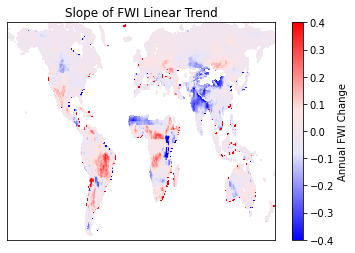

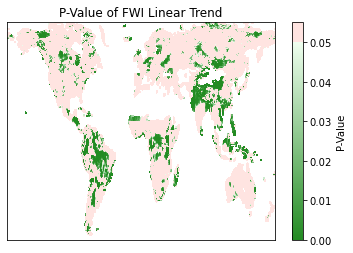

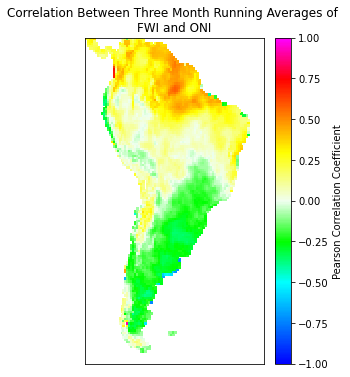

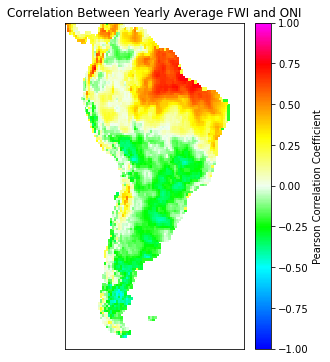

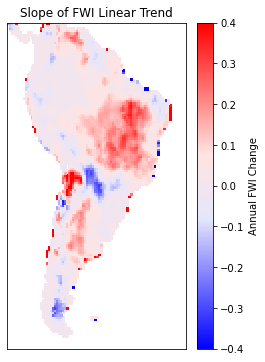

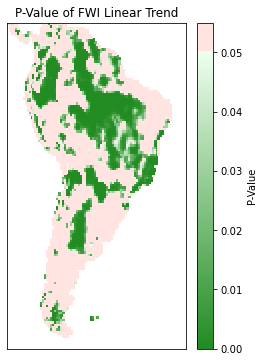

In [310]:
plt.figure(1)
colors1 = ['blue', 'lavender','mistyrose', 'red']
nodes1 = [0.0, 0.4, 0.6, 1.0]
cmap1 = LinearSegmentedColormap.from_list('mycmap', list(zip(nodes1,colors1)))
plt.pcolormesh(t_trend_slope*365.25,cmap = cmap1, vmin=-0.4, vmax=0.4)
plt.colorbar(label = 'Annual FWI Change')
plt.title('Slope of FWI Linear Trend')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.savefig('global_FWI_linear_trend_slope.png')

plt.figure(2)
colors2 = ['forestgreen', 'honeydew','mistyrose', 'mistyrose']
nodes2 = [0.0,11/12, 11/12, 1.0]
cmap2 = LinearSegmentedColormap.from_list('mycmap', list(zip(nodes2,colors2)))
plt.pcolormesh(t_trend_pvalue, cmap = cmap2, vmin=0, vmax=0.055)
plt.colorbar(label = 'P-Value')
plt.title('P-Value of FWI Linear Trend')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.savefig('global_FWI_linear_trend_pval')

plt.figure(3, figsize = ([4,6]))
colors3 = ['blue','cyan', 'lime','honeydew','yellow','red','magenta']
nodes3 = [0,.25,.375,.5,.65,.875,1]
cmap3 = LinearSegmentedColormap.from_list('mycmap', list(zip(nodes3,colors3)))
plt.pcolormesh(m_coeff[0:140,150:240], vmin=-1, vmax=1, cmap = cmap3)
plt.colorbar(label = 'Pearson Correlation Coefficient')
plt.title('Correlation Between Three Month Running Averages of \nFWI and ONI')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.savefig('three_month_correlation.png')

plt.figure(4, figsize = ([4,6]))
plt.pcolormesh(t_coeff[0:140,150:240], vmin=-1, vmax=1, cmap = cmap3)
plt.colorbar(label = 'Pearson Correlation Coefficient')
plt.title('Correlation Between Yearly Average FWI and ONI')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.savefig('yearly_correlation.png')

plt.figure(5, figsize = ([4,6]))
colors1 = ['blue', 'lavender','mistyrose', 'red']
nodes1 = [0.0, 0.4, 0.6, 1.0]
cmap1 = LinearSegmentedColormap.from_list('mycmap', list(zip(nodes1,colors1)))
plt.pcolormesh(t_trend_slope[0:140,150:240]*365.25,cmap = cmap1, vmin=-0.4, vmax=0.4)
plt.colorbar(label = 'Annual FWI Change')
plt.title('Slope of FWI Linear Trend')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.savefig('sa_FWI_linear_trend_slope.png')

plt.figure(6, figsize = ([4,6]))
colors2 = ['forestgreen', 'honeydew','mistyrose', 'mistyrose']
nodes2 = [0.0,11/12, 11/12, 1.0]
cmap2 = LinearSegmentedColormap.from_list('mycmap', list(zip(nodes2,colors2)))
plt.pcolormesh(t_trend_pvalue[0:140,150:240], cmap = cmap2, vmin=0, vmax=0.055)
plt.colorbar(label = 'P-Value')
plt.title('P-Value of FWI Linear Trend')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.savefig('sa_FWI_linear_trend_pval.png')

In [22]:
nc_date_key = np.array(nc_date_key)
print(len(nc_date_key[:-2]))

474


In [24]:
ncfile = Dataset('aggregate_data_6.nc', mode = 'w', format = 'NETCDF4_CLASSIC')
lat_dim = ncfile.createDimension('lat', 267)
lon_dim = ncfile.createDimension('lon', 576)
month_dim = ncfile.createDimension('month', 474)
year_dim = ncfile.createDimension('year', 38)
ncfile.title = 'Aggregated FWI Data'
ncfile.subtitle = 'Organized into a running three month average timeseries and a yearly average timeseries. Monthly data has linear trend and seasonal cycle removed.'
lat = ncfile.createVariable('lat', np.float32, ('lat',))
lat.units = 'degrees_north'
lat.long_name = 'latitude'
lon = ncfile.createVariable('lon',np.float32, ('lon',))
lon.units = 'degrees_east'
lon.long_name = 'longitude'
month = ncfile.createVariable('month', np.int32, ('month',))
month.units = 'yyyymm'
month.long_name = 'Month and Year of Monthly Data'
year = ncfile.createVariable('year', np.int32, ('year',))
month.units = 'yyyy'
yFWI = ncfile.createVariable('yFWI', np.float32, ('lat', 'lon', 'year'))
yFWI.units = 'Unitless'
yFWI.long_name = 'Annual average global fire weather index'
mFWI = ncfile.createVariable('mFWI', np.float32, ('lat', 'lon', 'month'))
mFWI.units = 'Unitless'
mFWI.long_name = '3 month running average global fire weather index'
yFWI[:,:,:] = yearly_array[:,:,:]
mFWI[:,:,:] = three_month_avg[:,:,:]
lat[:] = sample['lat'][:]
lon[:] = sample['lon'][:]
month[:] = nc_date_key[:-2]
year[:] = years_int
ncfile.close()

In [26]:
test = Dataset('aggregate_data_2.nc')
print(test)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Aggregated FWI Data
    subtitle: Organized into a running three month average timeseries and a yearly average timeseries. Monthly data has linear trend and seasonal cycle removed.
    dimensions(sizes): lat(267), lon(576), month(474), year(38)
    variables(dimensions): float32 lat(lat), float32 lon(lon), int32 month(month), int32 year(year), float32 yFWI(lat,lon,year), float32 mFWI(lat,lon,month)
    groups: 


<ipython-input-26-6e952b73ed7d>:2: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  print(test)
